In [2]:
import os, sys, re, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf
import time
from tensorflow import keras
print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

D:\360Downloads\Software\Anaconda3-5.0.1\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
tensorflow 2.0.0
matplotlib 2.0.2
numpy 1.18.2
pandas 0.20.3
sklearn 0.19.0
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
ORIGIN_DATA_DIR = os.getcwd() + '\\data\\BX-CSV-Dump\\'
FILTERED_DATA_DIR = os.getcwd() + '\\tmp\\'

In [4]:
class DataLoad:
    def __init__(self):
        self.BX_Users = self.load_origin('BX-Users')
        self.BX_Book_Ratings = self.load_origin('BX-Book-Ratings')
        self.books_with_blurbs = self.load_origin('books_with_blurbs', ',')
        #合并三个表
        self.features = self.get_features()
        self.labels = self.features.pop('Book-Rating')
    
    def load_origin(self,filename,sep="\";\""):
        """
        filename;根据文件名获取源文件，获取正确的columns、values等值
        sep:根据源文件的分割方式不同，通过传参改变分割方式sep="\":\""
        """
        try:
            #从缓存的文件夹Filter_data_dir获取基本被过滤的文件
            pickled_data = pickle.load(open(FILTERED_DATA_DIR+filename+'.p',mode='rb'))
            return pickled_data
        except FileNotFoundError:
            #如果缓存的文件不存在或者没有，则在ORIGIN_DATA_DIR获取
            all_fearures = pd.read_csv(ORIGIN_DATA_DIR+filename+'.csv',engine='python',sep = sep,encoding='utf-8')
            # \";\"  初始过滤的文件
            # ,      初始不需要过滤的文件
            data_dict = {"\";\"":self.filtrator(all_fearures), ',':all_fearures}
            # 因为没获得处理后的文件，所以我们在获取源文件后可以保存一下处理后的文件
            pickle.dump((data_dict[sep]), open(FILTERED_DATA_DIR+filename+'.p', 'wb'))
            return data_dict[sep]
        except UnicodeDecodeError as e:
            ''' 测试时经常会出现编码错误，如果尝试更换编码方式无效，可以将编码错误的部分位置重新复制粘贴就可以了，这里我们都默认UTF-8'''
            print('UnicodeDecodeError:',e)
        except pd.errors.ParserError as e:
            print("connect error|pandas Error: %s" % e)
        
    def filtrator(self,f_data):
        """
        f_data:需要初步进行filter的数据
        第一列的列名和最后一列的列名都带"
        """
        Nonetype_age = 0
        f_data = f_data.rename(columns={f_data.columns[0]:f_data.columns[0][1:], f_data.columns[-1]:f_data.columns[-1][:-1]})
        f_data[f_data.columns[0]] = f_data[f_data.columns[0]].map(lambda v:v[1:] if v!=None else Nonetype_age)
        f_data[f_data.columns[-1]] = f_data[f_data.columns[-1]].map(lambda v:v[:-1] if v!=None else Nonetype_age)
        try:
            f_data = f_data[f_data['Location'].notnull()][f_data[f_data['Location'].notnull()]['Location'].str.contains('\";NULL')]
            f_data['Location'] = f_data['Location'].map(lambda location:location[:-6])
        except:
            pass
        return f_data
    def get_features(self):
        """
        获取整个数据集的所有features，并对每个文本字段做处理
       User-ID:id2word
        Location：id2list
        ISBN：id2word
        Title：id2text
        Author：id2word
        Year：id2word
        Publisher：id2word
        Blurb:id2text
        """
        try:
            # 从缓存的文件夹FILTERED_DATA_DIR获取features的文件
            pickled_data = pickle.load(open(FILTERED_DATA_DIR+'features.p', mode='rb'))
            return pickled_data
        except FileNotFoundError:
            #将所有的数据组成features大表
            all_fearures = pd.merge(pd.merge(self.BX_Users,self.BX_Book_Ratings),self.books_with_blurbs)
            #删除age列
            all_fearures.pop('Age')
            all_fearures['Title'] = self.feature2int(all_fearures['Title'], 'text', 15)
            all_fearures['Blurb'] = self.feature2int(all_fearures['Blurb'], 'text', 200)
            all_fearures['ISBN'] = self.feature2int(all_fearures['ISBN'], 'word')
            all_fearures['Author'] = self.feature2int(all_fearures['Author'], 'word')
            all_fearures['Publisher'] = self.feature2int(all_fearures['Publisher'], 'word')
            all_fearures['User-ID'] = self.feature2int(all_fearures['User-ID'], 'word')
            all_fearures['Year'] = self.feature2int(all_fearures['Year'], 'word')
            all_fearures['Location'] = self.feature2int(all_fearures['Location'], 'list')
            all_fearures['Book-Rating'] = all_fearures['Book-Rating'].astype('float32')
            pickle.dump(all_fearures, open(FILTERED_DATA_DIR+'features.p', 'wb'))
            return all_fearures
    def feature2int(self, 
        feature:'特征值',
        feature_type:'text/word/list',
        length:'文本设置的最大长度' = 0,
        ):
        '''
        将文本字段比如title、blurb只取英文单词，并用空格为分隔符，做成一个带index值的集合，并用index值表示各个单词，作为文本得表示
        '''
        pattern = re.compile(r'[^a-zA-Z]')
#         filtered_map:匹配的一个规则
        filtered_map = {val:re.sub(pattern, ' ', str(val)) for ii,val in enumerate(set(feature)) }
#         1.letter_filter:非英文单词的用空格替换掉的一个匿名过滤的函数
        letter_filter = lambda feature:feature.map({val:re.sub(pattern, ' ', str(val)) for ii,val in enumerate(set(feature)) })
        text_words = set()
        filtered_feature = letter_filter(feature)
#         2.text_words:更新单词表set  
        for val in filtered_feature.str.split():
            text_words.update(val)
        text_words.add('<PAD>')
        text2int = {val:ii for ii, val in enumerate(text_words)}
        
        
        
        text_map = {val:[text2int[row] for row in filtered_map[val].split()][:length] for ii,val in enumerate(set(feature))}
    #按照索引值进行插入，超出索引值直接插0即可
        for key in text_map:
            for cnt in range(length - len(text_map[key])):
                text_map[key].insert(len(text_map[key]) + cnt,text2int['<PAD>'])     
        word_map = {val:ii for ii,val in enumerate(set(feature))}

        try:
            cities = set()
            for val in feature.str.split(','):
                cities.update(val)
            city_index = {val:ii for ii, val in enumerate(cities)}
            list_map = {val:[city_index[row] for row in val.split(',')][:3] for ii,val in enumerate(set(feature))}
        except AttributeError :
            list_map = {}
        feature_dict = {
            'text':feature.map(text_map),
            'word':feature.map(word_map),
            'list':feature.map(list_map),
            }
        return feature_dict[feature_type]

    def __del__(self):
        pass

In [5]:
data = DataLoad()

In [6]:
length  = [len(i) for i in data.features['Blurb']]
np.mean(np.array(length))

200.0

In [7]:
data.features.head()

,User-ID,Location,ISBN,Title,Author,Year,Publisher,Blurb
0,15870,"[6686, 1954, 7478]",18165,"[695, 6732, 9860, 20158, 20158, 20158, 20158, ...",2760,63,1833,"[28320, 119115, 852, 81179, 88419, 81651, 3727..."
1,15870,"[6686, 1954, 7478]",20412,"[5675, 10475, 13197, 19978, 325, 7154, 16184, ...",12723,71,2585,"[91516, 27939, 112885, 111528, 116700, 852, 11..."
2,9513,"[4926, 947, 7478]",20412,"[5675, 10475, 13197, 19978, 325, 7154, 16184, ...",12723,71,2585,"[91516, 27939, 112885, 111528, 116700, 852, 11..."
3,26193,"[5583, 6597, 5877]",20412,"[5675, 10475, 13197, 19978, 325, 7154, 16184, ...",12723,71,2585,"[91516, 27939, 112885, 111528, 116700, 852, 11..."
4,18261,"[2935, 7264, 5877]",20412,"[5675, 10475, 13197, 19978, 325, 7154, 16184, ...",12723,71,2585,"[91516, 27939, 112885, 111528, 116700, 852, 11..."


In [8]:
#User-ID number,max_index
all_user_id_number = len(set(data.features['User-ID']))
print('all_user_id_number=',all_user_id_number)

#Location number index
location_length = len(data.features['Location'][0])
all_location_words_number = max([j for i in data.features['Location'] for j in i])+1
print('location_length=%d,all_location_words_number=%d '% (location_length,all_location_words_number) )

#ISBN numner
all_isbn_words_number = len(set(data.features['ISBN']))
print('all_isbn_words_number ',all_isbn_words_number)

#Title
title_length = len(data.features['Title'][0])
all_title_words_number = max([j for i in data.features['Title'] for j in i])+1
print('title_length=%d,all_title_words_number=%d'% (title_length,all_title_words_number))

#Author
all_author_words_number = len(set(data.features['Author']))
print('all_author_words_number ',all_author_words_number)

#Year
all_year_words_number = len(set(data.features['Year']))
print('all_year_words_number ',all_year_words_number)

# Publisher
all_publisher_words_number = len(set(data.features['Publisher']))
print('all_publisher_words_number ',all_publisher_words_number)

# Blurb
blurb_length = len(data.features['Blurb'][0])
all_blurb_words_number = max([j for i in data.features['Blurb'] for j in i])+1
print('blurb_length=%d,all_blurb_words_number=%d'% (blurb_length,all_blurb_words_number))

all_user_id_number= 28836
location_length=3,all_location_words_number=7573 
all_isbn_words_number  38036
title_length=15,all_title_words_number=23816
all_author_words_number  15196
all_year_words_number  81
all_publisher_words_number  2909
blurb_length=200,all_blurb_words_number=127186


In [9]:
"""
超参数
"""
# Number of Epochs
num_epochs = 5
# Batch_size
batch_size = 256
# dropout_keep
dropout_keep = 0.5
# Learning_rate
learning_rate = 0.001
# embedding_dim
embedding_dim = 16
# 文本卷积滑动的单词个数
window_sizes = {2,3,4,5}
# filter num
filter_num = 8
# dense dim
dense_dim = 32

In [10]:
def get_inputs():
#     用户特征输入占位符
    # 用户特征输入
    user_id = keras.layers.Input(shape=(1,), dtype='int32', name='user_id_input')
    user_location = keras.layers.Input(shape=(3,), dtype='int32', name='user_location_input')
    
    # 书籍特征输入
    book_isbn = keras.layers.Input(shape=(1,),  dtype='int32', name='book_isbn_input')
    book_author = keras.layers.Input(shape=(1,),  dtype='int32', name='book_author_input')
    book_year = keras.layers.Input(shape=(1,),  dtype='int32', name='book_year_input')
    book_publisher = keras.layers.Input(shape=(1,),  dtype='int32', name='book_publisher_input')  
    book_title = keras.layers.Input(shape=(15, ), dtype='int32', name='book_title_input')
    book_blurb = keras.layers.Input(shape=(200, ), dtype='int32', name='book_blurb_input')
    return user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb

In [11]:
"""
构建User神经网络
"""
def get_user_embedding(user_id,user_location):
    uid_embed_layer = tf.keras.layers.Embedding(all_user_id_number,embedding_dim,input_length=1,name='uid_embed_layer')(user_id)
    location_embed_layer = tf.keras.layers.Embedding(all_location_words_number,embedding_dim,input_length=location_length,name='location_embed_layer')(user_location)
    return uid_embed_layer, location_embed_layer

In [12]:
def get_user_feature_layer(uid_embed_layer,location_embed_layer):
#     第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(dense_dim,name='uid_fc_layer',activation='relu')(uid_embed_layer)
    location_fc_layer = tf.keras.layers.Dense(dense_dim,name='location_fc_layer',activation='relu')(location_embed_layer)
#  对location进行Encoder提取特征
    location_gru_layer = tf.keras.layers.GRU(units=dense_dim,dropout=0.5,name='location_gru_layer')(location_fc_layer)
#     [None,32]
    print(location_gru_layer.shape)
    location_gru_expand_layer = tf.expand_dims(location_gru_layer,axis=1)
    
#     第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer,location_gru_expand_layer],2)
    user_dense_layer = tf.keras.layers.Dense(200,activation='tanh',name='user_dense_layer')(user_combine_layer)
    user_dense_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_dense_layer)
    return user_dense_layer,user_dense_layer_flat

In [13]:
"""
构建book神经网络
"""
def get_book_embedding(book_isbn, book_author, book_year, book_publisher, book_title, book_blurb):
    book_isbn_embed_layer = tf.keras.layers.Embedding(all_isbn_words_number,embedding_dim,input_length = 1,name='book_isbn_embed_layer')(book_isbn)
    book_author_embed_layer = tf.keras.layers.Embedding(all_author_words_number,embedding_dim,input_length=1,name='book_author_embed_layer')(book_author)
    book_year_embed_layer = tf.keras.layers.Embedding(all_year_words_number,embedding_dim,input_length=1,name='book_year_embed_layer')(book_year)
    book_publisher_embed_layer = tf.keras.layers.Embedding(all_publisher_words_number,embedding_dim,input_length = 1,name='book_publisher_embed_layer')(book_publisher)
    book_title_embed_layer = tf.keras.layers.Embedding(all_title_words_number,embedding_dim,input_length=title_length,name='book_title_embed_layer')(book_title)
    book_blurb_embed_layer = tf.keras.layers.Embedding(all_blurb_words_number,embedding_dim,input_length = blurb_length,name='book_blurb_embed_layer')(book_blurb)
    return book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer
    

In [14]:
def get_book_feature_layer(book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer):
#     对isbn,author,year,publisher第一层全连接
    book_isbn_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_isbn_dense_layer')(book_isbn_embed_layer)
    book_author_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_author_dense_layer')(book_author_embed_layer)
    book_year_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_year_dense_layer')(book_year_embed_layer)
    book_publisher_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_publisher_dense_layer')(book_publisher_embed_layer)
    book_title_embed_layer_expand = tf.expand_dims(book_title_embed_layer,axis=-1)
#     对title进行文本卷积
#     book_title_embed_layer_expand:[None,15,16,1]
#     对文本嵌入层使用不同的卷积核做卷积核最大池化
    pool_layer_list = []
    for window_size in window_sizes:
        title_conv_layer = tf.keras.layers.Conv2D(filters = filter_num,kernel_size = (window_size,embedding_dim),strides=1,activation='relu')(book_title_embed_layer_expand)
        title_maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(title_length-window_size+1,1),strides=1)(title_conv_layer)
        pool_layer_list.append(title_maxpool_layer)
    pool_layer_layer = tf.keras.layers.concatenate(pool_layer_list,axis=-1,name='title_pool_layer')
    max_num = len(window_sizes)*filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1,max_num],name='pool_layer_flat')(pool_layer_layer)
    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)

    # 对简介进行Encoder特征提取
    book_blurb_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_blurb_dense_layer')(book_blurb_embed_layer)
    book_blurb_gru_layer = tf.keras.layers.GRU(units=dense_dim,dropout=0.5,name='book_blurb_gru_layer')(book_blurb_dense_layer)
    print('book_blurb_gru_layer=',book_blurb_gru_layer.shape)
    book_blurb_gru_expand_layer = tf.expand_dims(book_blurb_gru_layer,axis=1)
    book_combine_layer = tf.keras.layers.concatenate([book_isbn_dense_layer,book_author_dense_layer,book_year_dense_layer,book_publisher_dense_layer,dropout_layer,book_blurb_gru_expand_layer],axis=-1)
    book_dense_layer = tf.keras.layers.Dense(200, activation='tanh')(book_combine_layer)
    book_dense_layer_flat = tf.keras.layers.Reshape([200], name="book_dense_layer_flat")(book_dense_layer)
    return book_dense_layer,book_dense_layer_flat

In [15]:
def get_rating(user_feature, book_feature):
    multiply_layer = keras.layers.Lambda(lambda layer: tf.reduce_sum(layer[0]*layer[1],axis=1,keepdims=True), name = 'user_book_feature')((user_feature, book_feature))
    print(multiply_layer.shape)
    return multiply_layer

In [16]:
a = tf.constant([[2,1,1],[1,3,4]])
b = tf.constant([[0,1,1],[1,0,4]])
c = inference = tf.keras.layers.Lambda(lambda layer:tf.reduce_sum(a * b, axis=1,keepdims=True))(a,b)
c.shape

TensorShape([2, 1])

In [17]:
features = data.features.values

In [18]:
features[0]


array([15870, list([6686, 1954, 7478]), 18165,
       list([695, 6732, 9860, 20158, 20158, 20158, 20158, 20158, 20158, 20158, 20158, 20158, 20158, 20158, 20158]),
       2760, 63, 1833,
       list([28320, 119115, 852, 81179, 88419, 81651, 37277, 83273, 17012, 31610, 30921, 96926, 1787, 18503, 118504, 79542, 70919, 3237, 57064, 852, 33928, 7410, 1787, 47611, 115409, 852, 1542, 116700, 852, 31279, 82172, 101336, 116700, 90011, 96045, 120308, 81651, 87798, 71052, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162, 117162

In [19]:
targets=data.labels.values
type(targets)

numpy.ndarray

In [20]:
# get_Batch
def get_batch(Xs,ys,batchsize):
    for start in range(0,len(Xx,batchsize)):
        end = min(start+batchsize,len(Xs))
        yield xS[start:end],ys[start:end]

# 构建计算图
将用户特征和书籍特征作为输入，经过一个全连接，输出预测

In [21]:
# test
a = np.array([[1, 2, 4, ([1, 2, 5])], 
             [3, 2, 6, ([6, 5, 1])],
             [6, 9, 4, ([3, 7, 5])]])
b = np.zeros([3,3])
for i in range(3):
    b[i] = a.take(3,1)[i]
b[:2]    

array([[1., 2., 5.],
       [6., 5., 1.]])

In [22]:
import math
dataset_length = len(features)

def get_train_val_test():
    location = np.zeros([dataset_length, 3])
    title = np.zeros([dataset_length, 15])
    blurb = np.zeros([dataset_length, 200])
    for i in range(dataset_length):
        location[i] = np.array(features[i, 1])
        title[i] = np.array(features[i, 3])
        blurb[i] = np.array(features[i, 7])
    input_features = [features.take(0, 1).astype(np.float64),
                      location,
                      features.take(2, 1).astype(np.float64),
                      title,
                      features.take(4, 1).astype(np.float64),
                      features.take(5, 1).astype(np.float64),
                      features.take(6, 1).astype(np.float64),
                      blurb]
    for i in range(len(input_features)):
        print(input_features[i].dtype)
        print(type(input_features[i]))
    labels = targets
    #     分割数据集以及shuffle
    np.random.seed(100)
    number_features = len(input_features)
    shuffle_index = np.random.permutation(dataset_length)
    shuffle_train_index = shuffle_index[:math.ceil(dataset_length * 0.96)]
    shuffle_val_index = shuffle_index[math.ceil(dataset_length * 0.96):math.ceil(dataset_length * 0.98)]
    shuffle_test_index = shuffle_index[math.ceil(dataset_length * 0.98):]
    train_features = [input_features[i][shuffle_train_index] for i in range(number_features)]
    train_labels = labels[shuffle_train_index]
    val_features = [input_features[i][shuffle_val_index] for i in range(number_features)]
    val_lables = labels[shuffle_val_index]
    test_features = [input_features[i][shuffle_test_index] for i in range(number_features)]
    test_lables = labels[shuffle_test_index]
    return train_features, train_labels, val_features, val_lables, test_features, test_lables

In [23]:
train_features, train_labels, val_features, val_lables, test_features, test_lables = get_train_val_test()
print(type(train_features))
print(type(train_labels))
print(val_features[0].shape)
print(test_features[0].shape)

float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
(3442,)
(3442,)


In [24]:
class mv_network(object):
    def __init__(self, batch_size,epoch):
        self.batchsize = 256
        self.epoch = 5
         # 获取输入占位符
        user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb = get_inputs()
        # 获取User的2个嵌入向量
        uid_embed_layer, location_embed_layer = get_user_embedding(user_id,user_location)
        # 得到用户特征
        user_dense_layer,user_dense_layer_flat =get_user_feature_layer(uid_embed_layer,location_embed_layer)
        # 获取书籍的嵌入向量
        book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer=get_book_embedding(book_isbn, book_author, book_year, book_publisher, book_title, book_blurb)
        # 获取书籍特征
        book_dense_layer,book_dense_layer_flat=get_book_feature_layer(book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer)
        
        # 计算出评分
        # 将用户特征和电影特征做矩阵乘法得到一个预测评分的方案
        print("user_dense_layer_flat=",user_dense_layer_flat.shape)
        print("book_dense_layer_flat=",book_dense_layer_flat.shape)
        inference = get_rating(user_dense_layer_flat,book_dense_layer_flat)

        # 将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
        #         inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, movie_combine_layer_flat],
        #                                                       1)  # (?, 400)
        # 你可以使用下面这个全连接层，试试效果
        # inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(
        #    inference_layer)
        #         inference = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense

        self.model = tf.keras.Model(
            inputs=[user_id, user_location, book_isbn, book_title, book_author, book_year, book_publisher, book_blurb],
            outputs=[inference])
        self.model.summary()
    def train_model(self):
        model_optimizer = tf.keras.optimizers.Adam()
        self.model.compile(optimizer=model_optimizer, loss=keras.losses.mse)
        history = self.model.fit(train_features, train_labels, validation_data=(val_features, val_lables), epochs=self.epoch, batch_size=self.batchsize, verbose=1)
        return  history
    def predict_model(self, model):
        test_loss = self.model.evaluate(test_features, test_lables, verbose=0)
        return test_loss

(None, 32)
book_blurb_gru_layer= (None, 32)
user_dense_layer_flat= (None, 200)
book_dense_layer_flat= (None, 200)
(None, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book_title_input (InputLayer)   [(None, 15)]         0                                            
__________________________________________________________________________________________________
book_title_embed_layer (Embeddi (None, 15, 16)       381056      book_title_input[0][0]           
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 15, 16, 1)]  0           book_title_embed_layer[0][0]     
__________________________________________________________________________________________________
user_location_input (InputLayer [(None, 3)]          0               

165218/165218 [==============================] - 343s 2ms/sample - loss: 13.0151 - val_loss: 11.5620
Epoch 2/5
165218/165218 [==============================] - 321s 2ms/sample - loss: 10.4039 - val_loss: 11.7905
Epoch 3/5
165218/165218 [==============================] - 319s 2ms/sample - loss: 8.9847 - val_loss: 12.4061
Epoch 4/5
165218/165218 [==============================] - 314s 2ms/sample - loss: 7.9888 - val_loss: 12.7829
Epoch 5/5
165218/165218 [==============================] - 320s 2ms/sample - loss: 7.2222 - val_loss: 13.6335


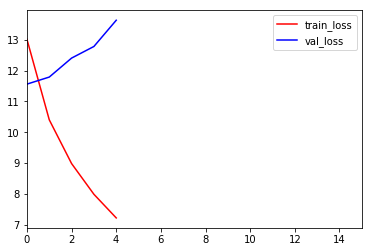

In [25]:
model = mv_network(256,5)
history = model.train_model()
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(1)
plt.plot(train_loss, c='r', label='train_loss')
plt.plot(val_loss, c='b', label='val_loss')
plt.legend()
plt.xlim([0, 15])
plt.show()

In [32]:
keras.utils.plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
